In [39]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


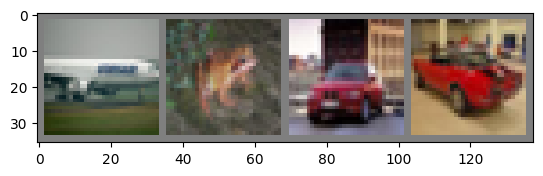

plane frog  car   car  


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [7]:
images.shape

torch.Size([4, 3, 32, 32])

In [55]:
## 
inp = images[0:2]
# .unsqueeze(0) # 1 x 3 x 32 x 32
print(f"input shape: {inp.shape}")
conv1 = nn.Conv2d(3, 6, 5)
print(conv1)
print(conv1(inp).shape) ## [1, 6, 28, 28]
pool = nn.MaxPool2d(2, 2)
print(pool)
print(pool(conv1(inp)).shape) ## [1, 6, 14, 14]
conv2 = nn.Conv2d(6, 16, 5) 
print(conv2(pool(conv1(inp))).shape) ## [1 x 16 x 10 x 10]
print(pool(conv2(pool(conv1(inp)))).shape) 
conv_out = pool(conv2(pool(conv1(inp))))
print(torch.flatten(conv_out, 1).shape)
conv_out = torch.flatten(conv_out, 1)
fc1 = nn.Linear(16 * 5 * 5, 120)
fc2 = nn.Linear(120, 84)
fc3 = nn.Linear(84, 10)
# F.relu(fc1(conv_out))
out = fc3(fc2(F.relu(fc1(conv_out))))
print(f"outshape: {out.shape}")
out.squeeze().shape

input shape: torch.Size([2, 3, 32, 32])
Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
torch.Size([2, 6, 28, 28])
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
torch.Size([2, 6, 14, 14])
torch.Size([2, 16, 10, 10])
torch.Size([2, 16, 5, 5])
torch.Size([2, 400])
outshape: torch.Size([2, 10])


torch.Size([2, 10])

In [46]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) 
        ## input: batch size, channels, w, h
        ## output: batch size, new channels, w_new, h_new
        ## w_new = (w_in + 2 * padding - kernel) / stride 
        ## 32 x 32 -> 5x5 kernel -> 28
        ## b x 6 x 28 x 28
        self.pool = nn.MaxPool2d(2, 2)
        ## kernel = 2, stride = 2 
        ## b x 6 x 14x14 
        self.conv2 = nn.Conv2d(6, 16, 5)
        ## b x 16 x 
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [47]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [48]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.170
[1,  4000] loss: 1.839
[1,  6000] loss: 1.675
[1,  8000] loss: 1.574
[1, 10000] loss: 1.515
[1, 12000] loss: 1.464
[2,  2000] loss: 1.395
[2,  4000] loss: 1.345
[2,  6000] loss: 1.331
[2,  8000] loss: 1.312
[2, 10000] loss: 1.278
[2, 12000] loss: 1.273
Finished Training
